In [1]:
"""Reference: https://github.com/nagypeterjob/Sentiment-Analysis-NLTK-ML-LSTM/blob/master/lstm.ipynb"""

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import utils
import models

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, CuDNNGRU, LSTM, GRU, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
import re
import zipfile

importlib.reload(utils)
importlib.reload(models)

Using TensorFlow backend.


<module 'models' from '/home/jerrysong/w266-Final-project/jerry/models.py'>

Only keeping the needed columns.

In [35]:
train_data = pd.read_csv('../data/fully_cleansed_train_data.csv', encoding='ISO-8859-1', keep_default_na=False)
dev_data = pd.read_csv('../data/fully_cleansed_dev_data.csv', encoding='ISO-8859-1', keep_default_na=False)
test_data = pd.read_csv('../data/fully_cleansed_test_data.csv', encoding='ISO-8859-1', keep_default_na=False)

In [36]:
train_data.head(10)

,text,sentiment
0,can someon fix twitter pleas smell of aquat ma...,0
1,just walk up stop stori escal at peachtre cent...,0
2,ye there proof two lovebird go to enjoy,4
3,im so sorri youtub video accident delet danc v...,0
4,want to go home now come back on thursday,0
5,mmmm shamrat arriv,4
6,go round aunit in pool x,4
7,cheer buddi will good see last night bit of ba...,4
8,sorri to hear will come kick ass in day if wan...,0
9,think time to retir saab,0


In [37]:
X_train = train_data['text'].values
X_dev = dev_data['text'].values
X_test = test_data['text'].values

print('train_data: ' + str(len(X_train)))
print('dev_data: ' + str(len(X_dev)))
print('test_data: ' + str(len(X_test)))

train_data: 1024000
dev_data: 256000
test_data: 320000


In [38]:
max_fatures = 20000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train)

In [39]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train)

X_dev = tokenizer.texts_to_sequences(X_dev)
X_dev = pad_sequences(X_dev, maxlen=X_train.shape[1])

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

In [40]:
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_dev: {}'.format(X_dev.shape))
print('The shape of X_test: {}'.format(X_test.shape))

The shape of X_train: (1024000, 117)
The shape of X_dev: (256000, 117)
The shape of X_test: (320000, 117)


In [41]:
Y_train = pd.get_dummies(train_data['sentiment']).values
Y_dev = pd.get_dummies(dev_data['sentiment']).values
Y_test = pd.get_dummies(test_data['sentiment']).values

print('The shape of Y_train: {}'.format(Y_train.shape))
print('The shape of Y_dev: {}'.format(Y_dev.shape))
print('The shape of Y_test: {}'.format(Y_test.shape))

The shape of Y_train: (1024000, 2)
The shape of Y_dev: (256000, 2)
The shape of Y_test: (320000, 2)


In [42]:
np.save('../sequence/x_train_word_20000', X_train)
np.save('../sequence/x_dev_word_20000', X_dev)
np.save('../sequence/x_test_word_20000', X_test)
np.save('../sequence/y_train', Y_train)
np.save('../sequence/y_dev', Y_dev)
np.save('../sequence/y_test', Y_test)

In [2]:
X_train = np.load('../sequence/x_train_word_10000.npy')
X_dev = np.load('../sequence/x_dev_word_10000.npy')
X_test = np.load('../sequence/x_test_word_10000.npy')
Y_train = np.load('../sequence/y_train.npy')
Y_dev = np.load('../sequence/y_dev.npy')
Y_test = np.load('../sequence/y_test.npy')

We should explore LSTM, CuDNNLSTM, GRU, CuDNNGRU cells. CuDNN cells have following limitations: 1. The activation function has to be `tanh`. 2. It doesn't support dropout.

In [10]:
# Hyperparameters tuning for LSTM: https://arxiv.org/pdf/1707.06799.pdf
max_fatures = 10000
embed_dim = 200
lstm_out = 128
input_length = X_train.shape[1]
epochs = 6
# The batch_size is very sensitive
batch_size = 64
# Why 0.5: https://www.reddit.com/r/MachineLearning/comments/3oztvk/why_50_when_using_dropout/
# Variational Dropout: https://arxiv.org/pdf/1512.05287.pdf
input_dropout = 0.5
recurrent_dropout = 0.5
embedding_layer = Embedding(max_fatures, embed_dim, input_length=input_length)

## CuDNNLSTM Baseline

In [15]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': True,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_data=[X_dev, Y_dev])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 99, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 99, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               241600    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 2,242,002
Trainable params: 2,242,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
 - 669s - loss: 0.4353 - acc: 0.7972 - val_loss: 0.4137 - val_acc: 0.8107
Epoch 2/5
 - 669s - loss: 0.4030 - acc: 0.8158 - val_loss: 0.4066 - val_acc: 0.8163
Epoch 3/5
 - 669s - loss: 0.3897 - acc

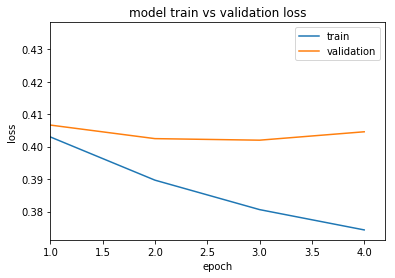

score: 0.40240706
acc: 0.81894375


In [16]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with 5 Epochs

In [23]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 3,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': False,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_data=[X_dev, Y_dev])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 200)           4000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 4,121,002
Trainable params: 4,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/3
 - 299s - loss: 0.4174 - acc: 0.8076 - val_loss: 0.3887 - val_acc: 0.8236
Epoch 2/3
 - 299s - loss: 0.3793 - acc: 0.8294 - val_loss: 0.3799 - val_acc: 0.8280
Epoch 3/3
 - 299s - loss: 0.3634 - acc

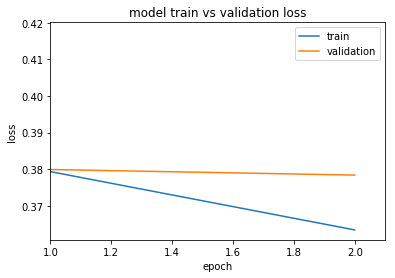

score: 0.39165074
acc: 0.82172702


In [26]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with 5 Epochs and 2 LSTM Layers

In [29]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 2,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 40, 100)           120800    
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 2,201,802
Trainable params: 2,201,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 160s - loss: 0.4274 - acc: 0.8015 - val_loss: 0.4013 - val_ac

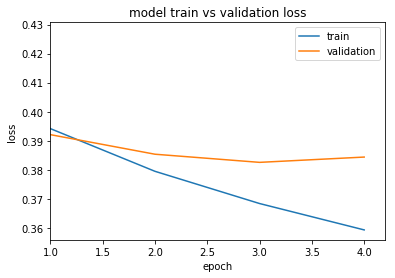

score: 0.39044503
acc: 0.81894150


In [30]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNGRU with 5 Epochs

In [31]:
params = {
    'model_type': CuDNNGRU,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100)               90600     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 2,090,802
Trainable params: 2,090,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 93s - loss: 0.4287 - acc: 0.8012 - val_loss: 0.4021 - val_acc: 0.8166
Epoch 2/5
 - 92s - loss: 0.3942 - acc: 0.8209 - val_loss: 0.3913 - val_acc: 0.8220
Epoch 3/5
 - 92s - loss: 0.3803 - acc: 0

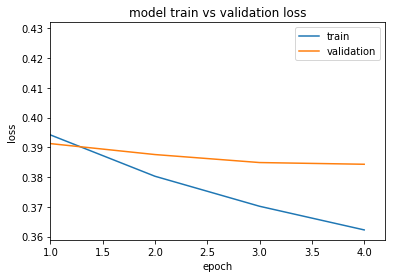

score: 0.39041958
acc: 0.81197772


In [32]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## LSTM with 5 Epochs and 0.5 Recurrent Dropout

In [ ]:
params = {
    'model_type': LSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': 0.5,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

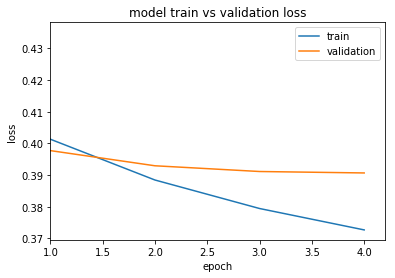

score: 0.37285437
acc: 0.82729806


In [34]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with 5 Epochs and Glove Embedding

In [10]:
# Skip customized data preprocessing when use pre-trained embedding

params = {
    'model_type': CuDNNLSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': tokenizer.word_index,
    'embedding_pretrained_zip_path': '../glove.twitter.27B.zip',
    'embedding_pretrained_name': 'glove.twitter.27B.200d.txt',
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': 0.5,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 117, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 117, 200)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 4,121,002
Trainable params: 4,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 238s - loss: 0.4194 - acc: 0.8068 - val_loss: 0.3906 - val_acc: 0.8228
Epoch 2/5
 - 238s - loss: 0.3803 - acc: 0.8285 - val_loss: 0.3826 - val_acc: 0.8270
Epoch 3/5
 - 239s - loss: 0.3628 - acc

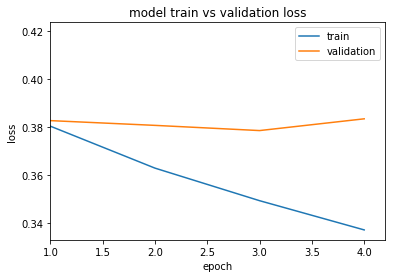

score: 0.42819649
acc: 0.80501394


In [15]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 256)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## Bidirectional LSTM with 5 Epochs and 0.5 Recurrent Dropout

In [45]:
params = {
    'model_type': LSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': 0.5,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': True,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_data=[X_dev, Y_dev])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 38, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 38, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 2,241,202
Trainable params: 2,241,202
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 814s - loss: 0.4353 - acc: 0.7975 - val_loss: 0.4066 - val_acc: 0.8138
Epoch 2/5
 - 812s - loss: 0.4013 - acc: 0.8168 - val_loss: 0.3958 - val_acc: 0.8201
Epoch 3/5
 - 812s - loss: 0.3885 - acc

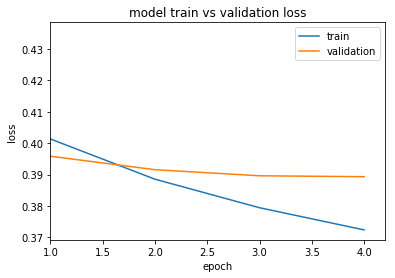

score: 0.37662466
acc: 0.82451253


In [47]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

Extracting a validation set, and measuring score and accuracy.

To improve:
1. The model is suffering from overfitting. We should add more dropout layers and try other regularization methods.
2. Systematically search for the optimal combination of hyperparameters
3. Try pretrained embedding, bidirectional RNN, combination of word and character level embedding (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)